# Image Captioning model with Attention Mechanism
A deep learning model for image captioning using a combination of Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs), specifically a Long Short-Term Memory (LSTM) network.


In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer, Attention, Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
from textwrap import wrap
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import pickle
from tqdm.notebook import tqdm
from keras.applications import MobileNetV3Small
from keras.preprocessing import image
from nltk.translate import bleu_score as nltk_bleu_score
from pycocoevalcap.cider.cider import Cider

In [2]:
# Loadign the dataset
image_path = 'Images/'
data = pd.read_csv("captions.txt") 
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [3]:
#Read Images
img_size = 224

def readImage(path,img_size=img_size):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 22))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))

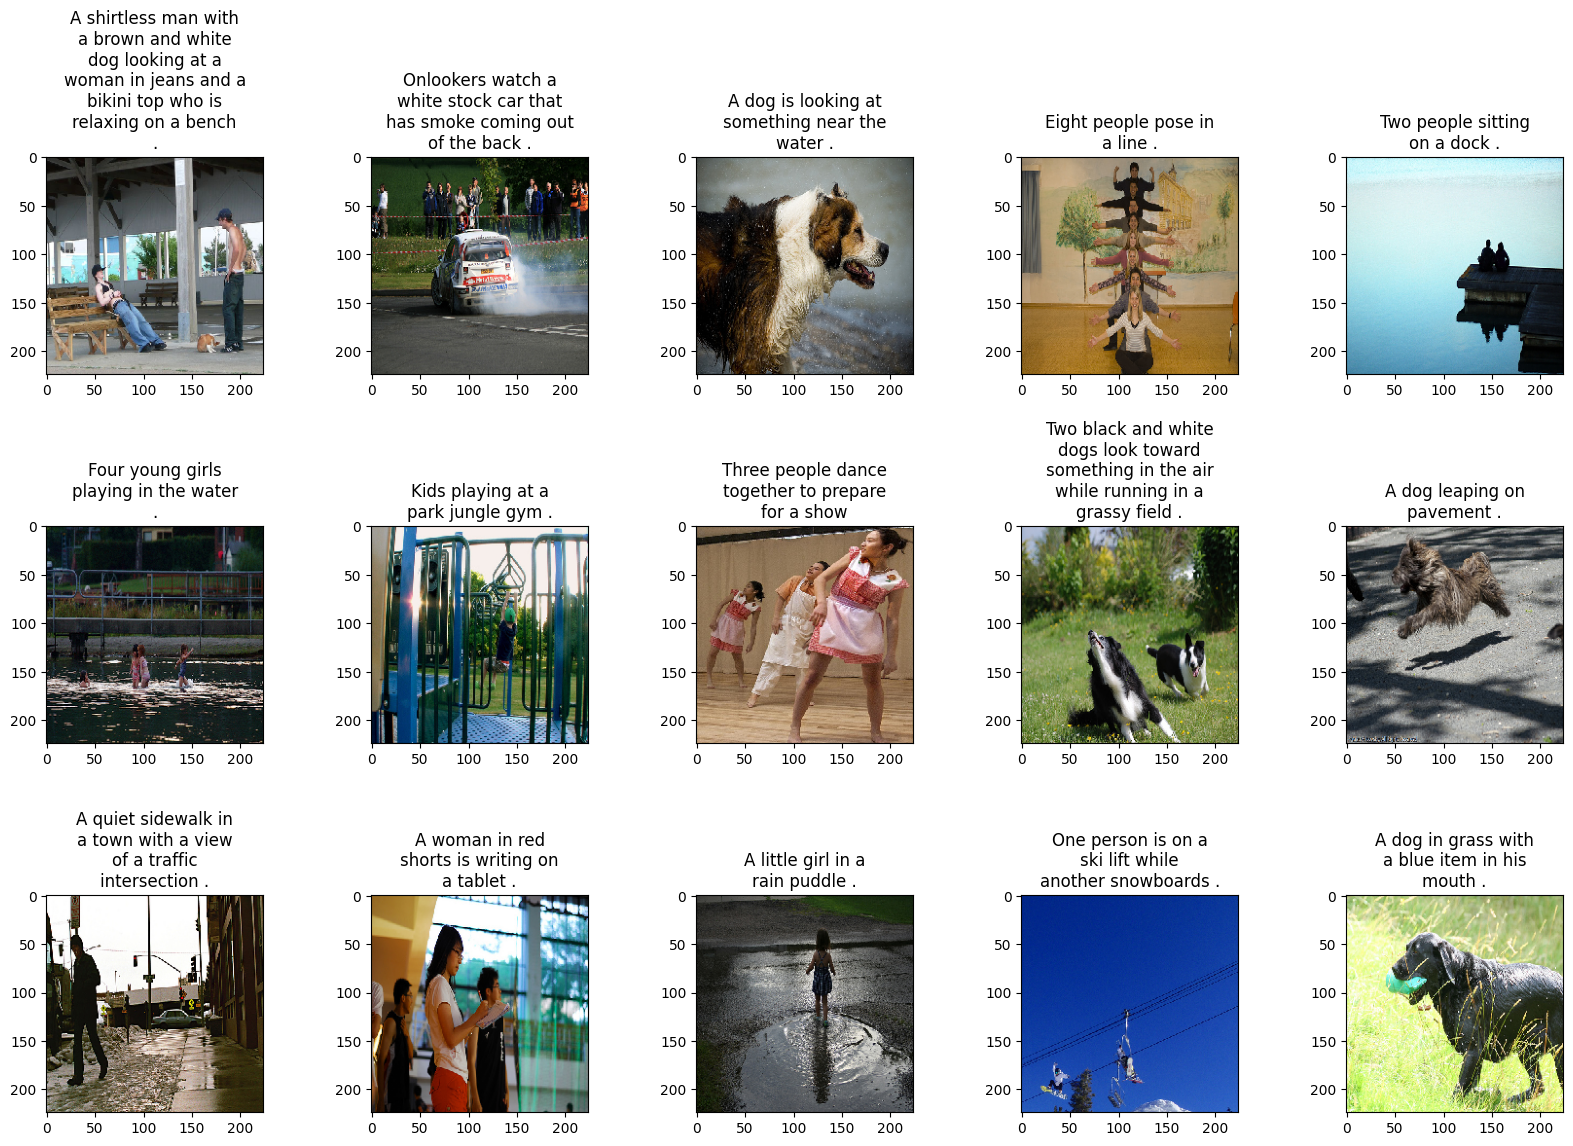

In [4]:
#Display the images
display_images(data.sample(15))

In [16]:
#Text preprocessing
def preprocess_text(text):
    tokens = word_tokenize(str(text))
    tokens = [token.lower() for token in tokens if token not in string.punctuation and token.isalnum() and token.strip()]
    preprocessed_str = ' '.join(tokens)
    return preprocessed_str

data['caption'] = data['caption'].apply(preprocess_text)
captions = data['caption'].tolist()

#Tokenization
for i in range(0,2):
    print("\n",captions[i])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

#Converting text to sequences
for i in range(0, 2):
    print("\n", tokenizer.texts_to_sequences([captions[i]]))
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)


 a child in a pink dress is climbing up a set of stairs in an entry way

 a girl going into a wooden building

 [[1, 40, 2, 1, 88, 167, 5, 117, 51, 1, 391, 10, 388, 2, 26, 5104, 689]]

 [[1, 17, 310, 62, 1, 191, 115]]


In [6]:
#Train, Test and Validation split
image_list = data['image'].unique().tolist()

train_set, test_set = train_test_split(image_list, test_size=0.2, shuffle=True, random_state=42)
train_set, val_set = train_test_split(train_set, test_size=0.2, shuffle=True, random_state=42)


train = data[data['image'].isin(train_set)]
test = data[data['image'].isin(test_set)]
val = data[data['image'].isin(val_set)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)
val.reset_index(inplace=True,drop=True)

#Print shapes of the train test and validation set
print("train_set shape:", train.shape, "\nval_set shape:", val.shape, "\ntest_set shape:", test.shape)

train_set shape: (25885, 2) 
val_set shape: (6475, 2) 
test_set shape: (8095, 2)


In [7]:
dump_file_name = 'mobilenet_feature.pkl'
base_model = MobileNetV3Small()
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

#Extracting fearures
def extract_features():

    img_size = 224
    features = {}
    for image in tqdm(data['image'].unique().tolist()):
        img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
        img = img_to_array(img)
        img = img/255.
        img = np.expand_dims(img,axis=0)
        feature = model.predict(img, verbose=0)
        features[image] = feature
    return features

# Loading and Extracting Features
if os.path.exists(dump_file_name):
    with open(dump_file_name, 'rb') as handle:
        features = pickle.load(handle)
else:
    features = extract_features()
    with open(dump_file_name, 'wb') as handle:
        pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

In [9]:
#Model Architecture
input1 = Input(shape=(1000,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
attention_layer = Attention(use_scale=True, score_mode="dot")
context_vector = attention_layer([x, x]) 
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

#Output layer
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [10]:
#Print Summary 
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          256256      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

In [11]:
class CustomDataGenerator(Sequence):
    #Constructor method for initializing the CustomDataGenerator object.
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    #Method to determine the number of batches in the generator.
    def __len__(self):
        return self.n // self.batch_size
    
    #Method to fetch data for a given batch index.
    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    #Method to preprocess data for a given batch.
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [12]:
# Create training data generator
train_generator = CustomDataGenerator(df=train,
                                      X_col='image',
                                      y_col='caption',
                                      batch_size=64,
                                      directory=image_path,
                                      tokenizer=tokenizer,
                                      vocab_size=vocab_size,
                                      max_length=max_length,
                                      features=features)

# Create validation data generator
val_generator = CustomDataGenerator(df=val,
                                     X_col='image',
                                     y_col='caption',
                                     batch_size=64,
                                     directory=image_path,
                                      tokenizer=tokenizer,
                                     vocab_size=vocab_size,
                                     max_length=max_length,
                                     features=features)

# Create test data generator
test_generator = CustomDataGenerator(df=test,
                                     X_col='image',
                                     y_col='caption',
                                     batch_size=64,
                                     directory=image_path,
                                      tokenizer=tokenizer,
                                     vocab_size=vocab_size,
                                     max_length=max_length,
                                     features=features)

In [13]:
len(train_generator)

404

In [14]:
# Define model name
model_name = "mobilenetv3small_with_attention.keras"

# Define checkpoint to save the best model
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

# Define early stopping to prevent overfitting
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0,
                              patience = 10, verbose = 1, 
                              restore_best_weights=True)

In [ ]:
# Train the model
history = caption_model.fit(
        train_generator,
        epochs=250,
        validation_data=val_generator,
        callbacks=[checkpoint,earlystopping])

Epoch 1/250
404/404 [==============================] - ETA: 0s - loss: 6.3310
Epoch 1: val_loss improved from inf to 5.76962, saving model to mobilenetv3small_with_attention.keras
404/404 [==============================] - 150s 356ms/step - loss: 6.3310 - val_loss: 5.7696
Epoch 2/250
404/404 [==============================] - ETA: 0s - loss: 5.6886
Epoch 2: val_loss improved from 5.76962 to 5.39924, saving model to mobilenetv3small_with_attention.keras
404/404 [==============================] - 45s 110ms/step - loss: 5.6886 - val_loss: 5.3992
Epoch 3/250
404/404 [==============================] - ETA: 0s - loss: 5.3172
Epoch 3: val_loss improved from 5.39924 to 5.14052, saving model to mobilenetv3small_with_attention.keras
404/404 [==============================] - 45s 110ms/step - loss: 5.3172 - val_loss: 5.1405
Epoch 4/250
404/404 [==============================] - ETA: 0s - loss: 5.0898
Epoch 4: val_loss improved from 5.14052 to 4.92304, saving model to mobilenetv3small_with_attenti

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
#Compute the CIDEr score between true and predicted captions.
def compute_cider(y_true, y_pred):
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score({i: [ref] for i, ref in enumerate(y_true)}, {i: [pred] for i, pred in enumerate(y_pred)})
    return cider_score

#Compute the BLEU score between true and predicted captions.
def compute_bleu(y_true, y_pred):
    bleu_score = nltk_bleu_score.corpus_bleu([[ref] for ref in y_true], y_pred)
    return bleu_score

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
#Calculate the loss and generate predictions
def calculate_loss_and_predict(samples, caption_model, tokenizer, max_length, features, image_path):
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    losses = []
    predictions = []

    for index, record in samples.iterrows():
        img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
        img = img_to_array(img) / 255.

        caption = ""
        for i in range(max_length):
            sequence = tokenizer.texts_to_sequences([caption])[0]
            sequence = pad_sequences([sequence], max_length)
            y_pred = caption_model.predict([features[record['image']], sequence])
            y_pred = np.argmax(y_pred)
            word = idx_to_word(y_pred, tokenizer)
            if word is None:
                break
            caption += word

        predictions.append({'image': record['image'], 'caption': caption})

        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], max_length)
        target = to_categorical(sequence, num_classes=len(tokenizer.word_index) + 1)
        y_pred = caption_model.predict([features[record['image']], sequence])
        y_true = target[:, 1:]
        loss = loss_fn(y_true, y_pred)
        losses.append(loss)

    average_loss = np.mean(losses)

    return average_loss, pd.DataFrame(predictions)

In [ ]:
#Display images with predicted captions
display_images(samples)